### Imports

In [1]:
import os
import sys
import random

In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
from torchvision.transforms import InterpolationMode

In [6]:
# our library
from svetlanna import SimulationParameters
from svetlanna import elements
from svetlanna import Wavefront

In [7]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Raw [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Load a dataset from `torchvision` in the selected directory and create train and test datasets.

In [8]:
# initialize a directory for a dataset
data_filepath = './data'  # folder to store data

In [9]:
import ssl
# to solve the problem with cerificates while downloading a dataset using torchvision
# solution from: https://github.com/pytorch/pytorch/issues/33288#issuecomment-954160699
ssl._create_default_https_context = ssl._create_unverified_context

### 1.1. Train dataset

In [10]:
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=True,
    # transform=transforms.ToTensor()  # <- transforms images to tensors
)

len(mnist_train_ds)

60000

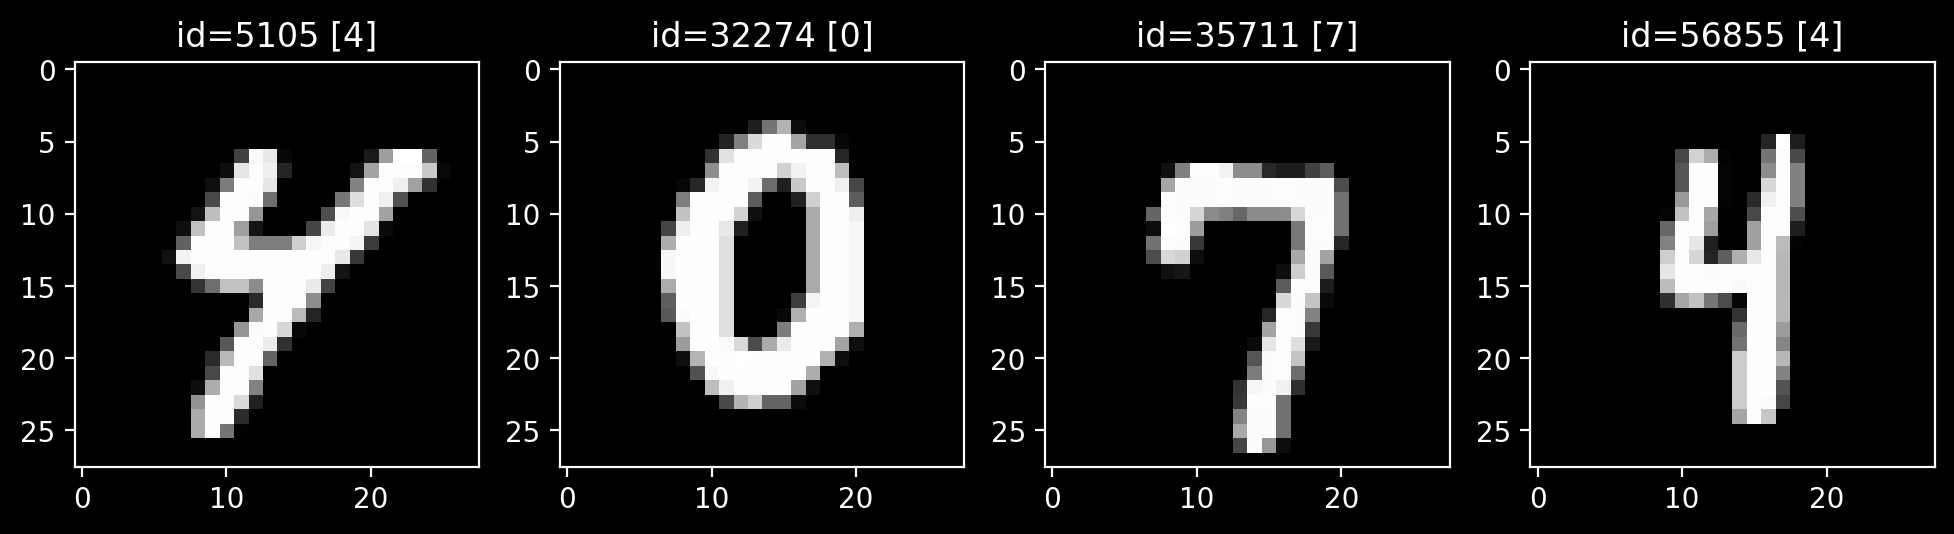

In [11]:
# plot several images
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 3))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, target = mnist_train_ds[ind_train]

    axs[ind_ex].set_title(f'id={ind_train} [{target}]')
    axs[ind_ex].imshow(image, cmap='gray')

plt.show()

Each image is of the size `torch.Size([1, 28, 28])`

### 1.2. Test dataset

In [12]:
mnist_test_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=False,  # for test dataset
    download=True,
    # transform=transforms.ToTensor()
)

len(mnist_test_ds)

10000

### 1.3. Types for datasets

In [13]:
# what is a type of the objects?
type(mnist_train_ds)

torchvision.datasets.mnist.MNIST

In [14]:
# check if created objects are instances of class Dataset
assert isinstance(mnist_train_ds, Dataset)
assert isinstance(mnist_test_ds, Dataset)

## 2. Dataset of wavefronts

### 2.1. Wavefronts dataset class obtained with SLM

In [15]:
class WavefrontsDatasetWithSLM(Dataset):
    """
    Dataset of wavefronts for a classification task for an optical network.
        Each raw image is used as a mask for SLM, that illuminated by a some beam field.
        A resulted wavefront will be an input tensor for an optical network.
    """
    def __init__(
        self, 
        images_ds: Dataset,
        image_transforms_comp: transforms.Compose,
        sim_params: SimulationParameters,
        beam_field: torch.Tensor,
        system_before_slm: list,
        slm_levels: int = 256
    ):
        """
        Parameters
        ----------
        images_ds : torch.utils.data.Dataset
            A dataset of raw images and classes labels.
        image_transforms_comp : transforms.Compose
            A sequence of transforms that will be applied to an image before its convertation to an SLM mask.
        sim_params : SimulationParameters
            Simulation parameters for a further optical network.
        beam_field : torch.Tensor
            A field of a beam (result of Beam.forward) that is used for an images wavefronts generation.
        system_before_slm : list(Element)
            A list of Elements between a beam and an SLM. The beam field is going through them before the SLM.
        slm_levels : int
            Number of phase quantization levels for the SLM, by default 256
        """
        self.images_ds = images_ds
        self.image_transforms_comp = image_transforms_comp
        
        self.sim_params = sim_params

        self.beam_field = beam_field
        # QUESTION: then we can extract simulation parameters from every element? 
        self.system_before_slm = system_before_slm

        self.slm_levels = slm_levels

    def __len__(self):
        return len(self.images_ds)

    def __getitem__(self, ind: int) -> tuple:
        """
        Parameters
        ----------
        ind : int
            Index of element to return.

        Returns
        -------
        tuple
            An element of dataset: tuple(wavefront tensor, class)
            A size of a wavefront is in correspondence with simulation parameters!
        """
        raw_image, label = self.images_ds[ind]
        # apply transforms
        transformed_image = self.image_transforms_comp(raw_image)
        
        # we need to resize an image to match simulation parameters (layers dimensions)
        # check (last two dimensions) if we already resized an image by applying self.image_transforms_comp
        y_nodes, x_nodes = self.sim_params.y_nodes, self.sim_params.x_nodes
        if not transformed_image.size()[-2:] == torch.Size([y_nodes, x_nodes]):
            resize = transforms.Resize(
                size=(y_nodes, x_nodes),
                # interpolation=InterpolationMode.NEAREST,  # <- interpolation function?
            )  # by default applies to last two dimensions!
            transformed_image = resize(transformed_image)

        # secondly, we must somehow transform an image to a wavefront
        output_field = self.beam_field
        for element in self.system_before_slm:
            output_field = element.forward(input_field=output_field)

        # use an image as a mask for SLM
        # TODO: make it possible to use a mask of any values (add normalization by levels within an SLM)
        mask = (transformed_image * (self.slm_levels - 1)).to(torch.int32)
        image_based_slm = elements.SpatialLightModulator(
            simulation_parameters=self.sim_params,
            mask=mask,
            number_of_levels=self.slm_levels
        )
        
        wavefront_image = image_based_slm.forward(output_field)
        
        return wavefront_image, label

#### 2.1.2. Parameters for a dataset of wavefronts (with SLM)

In [16]:
# simulation parameters
x_nodes = 100
y_nodes = x_nodes

x_size = 20 * 1e-2  # [m]
y_size = x_size  # [m]

wavelength = 1000 * 1e-9  # [m]

sim_params = SimulationParameters(
    x_size=x_size,  # [m]
    y_size=y_size,  # [m]
    x_nodes=x_nodes,
    y_nodes=y_nodes,
    wavelength=wavelength  # [m]
)

In [17]:
# generation of a beam wavefront, using new Wavefront class: 
prop_distance = 0  # [m]

beam_wavefront = Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=5 * 1e-2,  # [m]
    distance=prop_distance,  # [m]
)

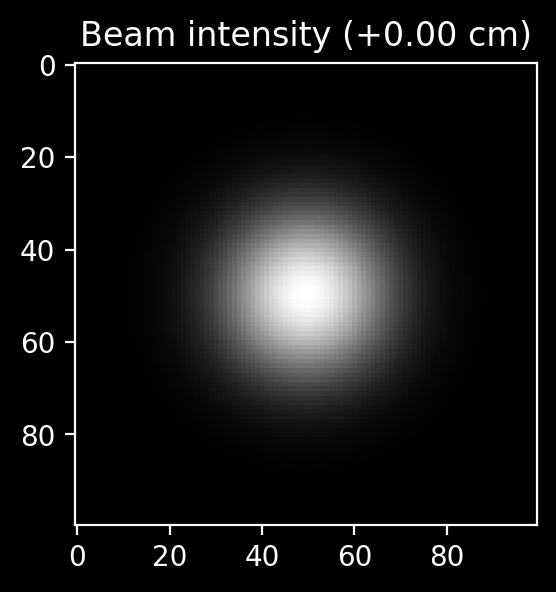

In [18]:
# let's take a look at a beam intensity distribution
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Beam intensity (+{prop_distance * 100:.2f} cm)')
ax0.imshow(beam_wavefront.intensity, cmap='gray')

plt.show()

In [19]:
# specify system before slm for a further dataset of wavefronts
free_space_1 = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=1 * 1e-2,  # [m]
    method='AS'
)

system_before_slm = [
    free_space_1
]

### 2.1.2 Train and Test datasets of wavefronts

In [20]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(y_nodes, x_nodes),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [21]:
# train dataset
mnist_wf_train_ds = WavefrontsDatasetWithSLM(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
    beam_field=beam_wavefront,
    system_before_slm=system_before_slm,
    slm_levels=256
)

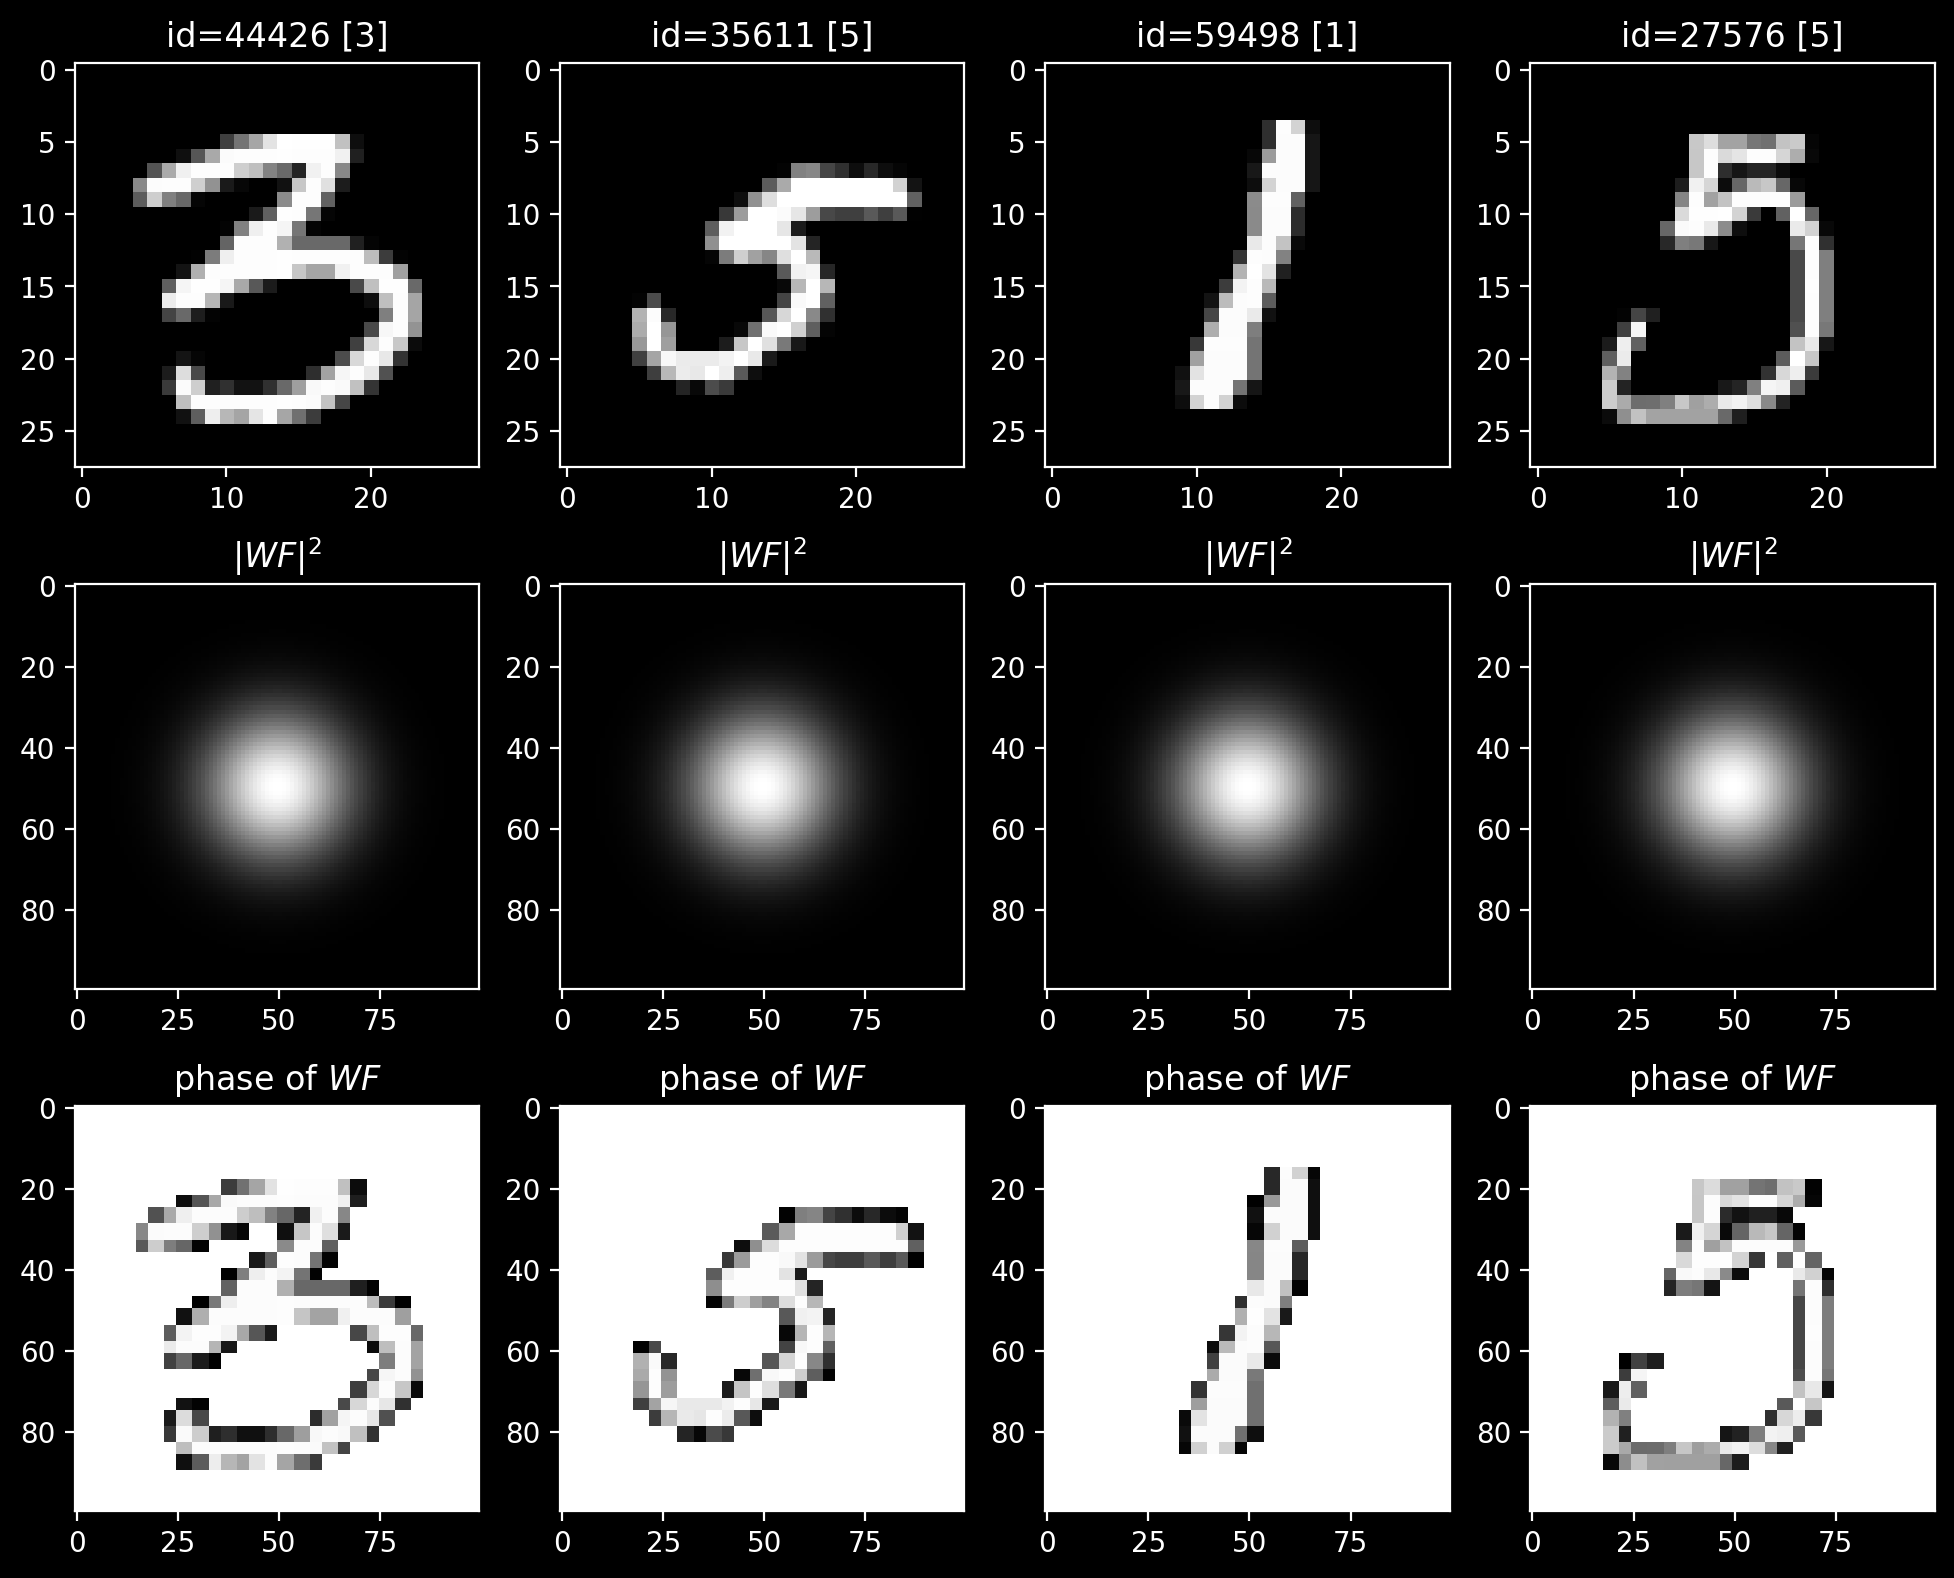

In [22]:
# plot several images
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(wavefront.intensity[0], cmap='gray')
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(wavefront.phase[0], cmap='gray')

plt.show()

In [23]:
# test dataset
mnist_wf_test_ds = WavefrontsDatasetWithSLM(
    images_ds=mnist_test_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,
    sim_params=sim_params,  # simulation parameters
    beam_field=beam_wavefront,
    system_before_slm=system_before_slm,
    slm_levels=256
)

In [24]:
print(f'Train data: {len(mnist_wf_train_ds)}')
print(f'Test data : {len(mnist_wf_test_ds)}')

Train data: 60000
Test data : 10000


### 2.2. Wavefronts dataset class (an image as an amplitude and/or a phase)

In [25]:
class WavefrontsDatasetSimple(Dataset):
    """
    Dataset of wavefronts for a classification task for an optical network.
        Each raw image is encoded in the amplitude and/or phase.
    """
    def __init__(
        self, 
        images_ds: Dataset,
        image_transforms_comp: transforms.Compose,
        sim_params: SimulationParameters,
    ):
        """
        Parameters
        ----------
        images_ds : torch.utils.data.Dataset
            A dataset of raw images and classes labels.
        image_transforms_comp : transforms.Compose
            A sequence of transforms that will be applied to an image before its convertation to an SLM mask.
        sim_params : SimulationParameters
            Simulation parameters for a further optical network.
        """
        # TODO: add a parameter for choosing what to use to encode an image: use only amplitude/phase or both?
        self.images_ds = images_ds
        self.image_transforms_comp = image_transforms_comp
        
        self.sim_params = sim_params

    def __len__(self):
        return len(self.images_ds)

    def __getitem__(self, ind: int) -> tuple:
        """
        Parameters
        ----------
        ind : int
            Index of element to return.

        Returns
        -------
        tuple
            An element of dataset: tuple(wavefront tensor, class)
            A size of a wavefront is in correspondence with simulation parameters!
        """
        raw_image, label = self.images_ds[ind]
        # apply transforms
        transformed_image = self.image_transforms_comp(raw_image)
        transformed_image_size = transformed_image.size()[-2:]  # [H, W]
        
        # we need to resize an image to match simulation parameters (layers dimensions)
        y_nodes, x_nodes = self.sim_params.y_nodes, self.sim_params.x_nodes
        # check (last two dimensions) if transformations result in a proper size
        if not transformed_image_size == torch.Size([y_nodes, x_nodes]):
            # add padding if transformed_image is not match with sim_params!
            pad_top = int((y_nodes - transformed_image_size[0]) / 2)
            pad_bottom = y_nodes - pad_top - transformed_image_size[0]
            pad_left = int((x_nodes - transformed_image_size[1]) / 2)
            pad_right = x_nodes - pad_left - transformed_image_size[1]
            
            padding = transforms.Pad(
                padding=(pad_left, pad_top, pad_right, pad_bottom),  # [left, top, right, bottom]
                fill=0,
            )
            transformed_image = padding(transformed_image)

        # secondly, we must create a wavefront based on the image
        max_val = transformed_image.max()
        min_val = transformed_image.min()
        normalized_image = (transformed_image - min_val) / (max_val - min_val)  # values from 0 to 1
        
        # TODO: use only amplitude/phase or both?
        phases = normalized_image * torch.pi
        amplitudes = normalized_image
        
        wavefront_image = Wavefront(amplitudes * torch.exp(1j * phases))
        
        return wavefront_image, label

### 2.2.1 Each image can be encoded as an amplitude and phase distribution

In [26]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(int(y_nodes / 2), int(x_nodes / 2)),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [27]:
# train dataset
mnist_wf02_train_ds = WavefrontsDatasetSimple(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

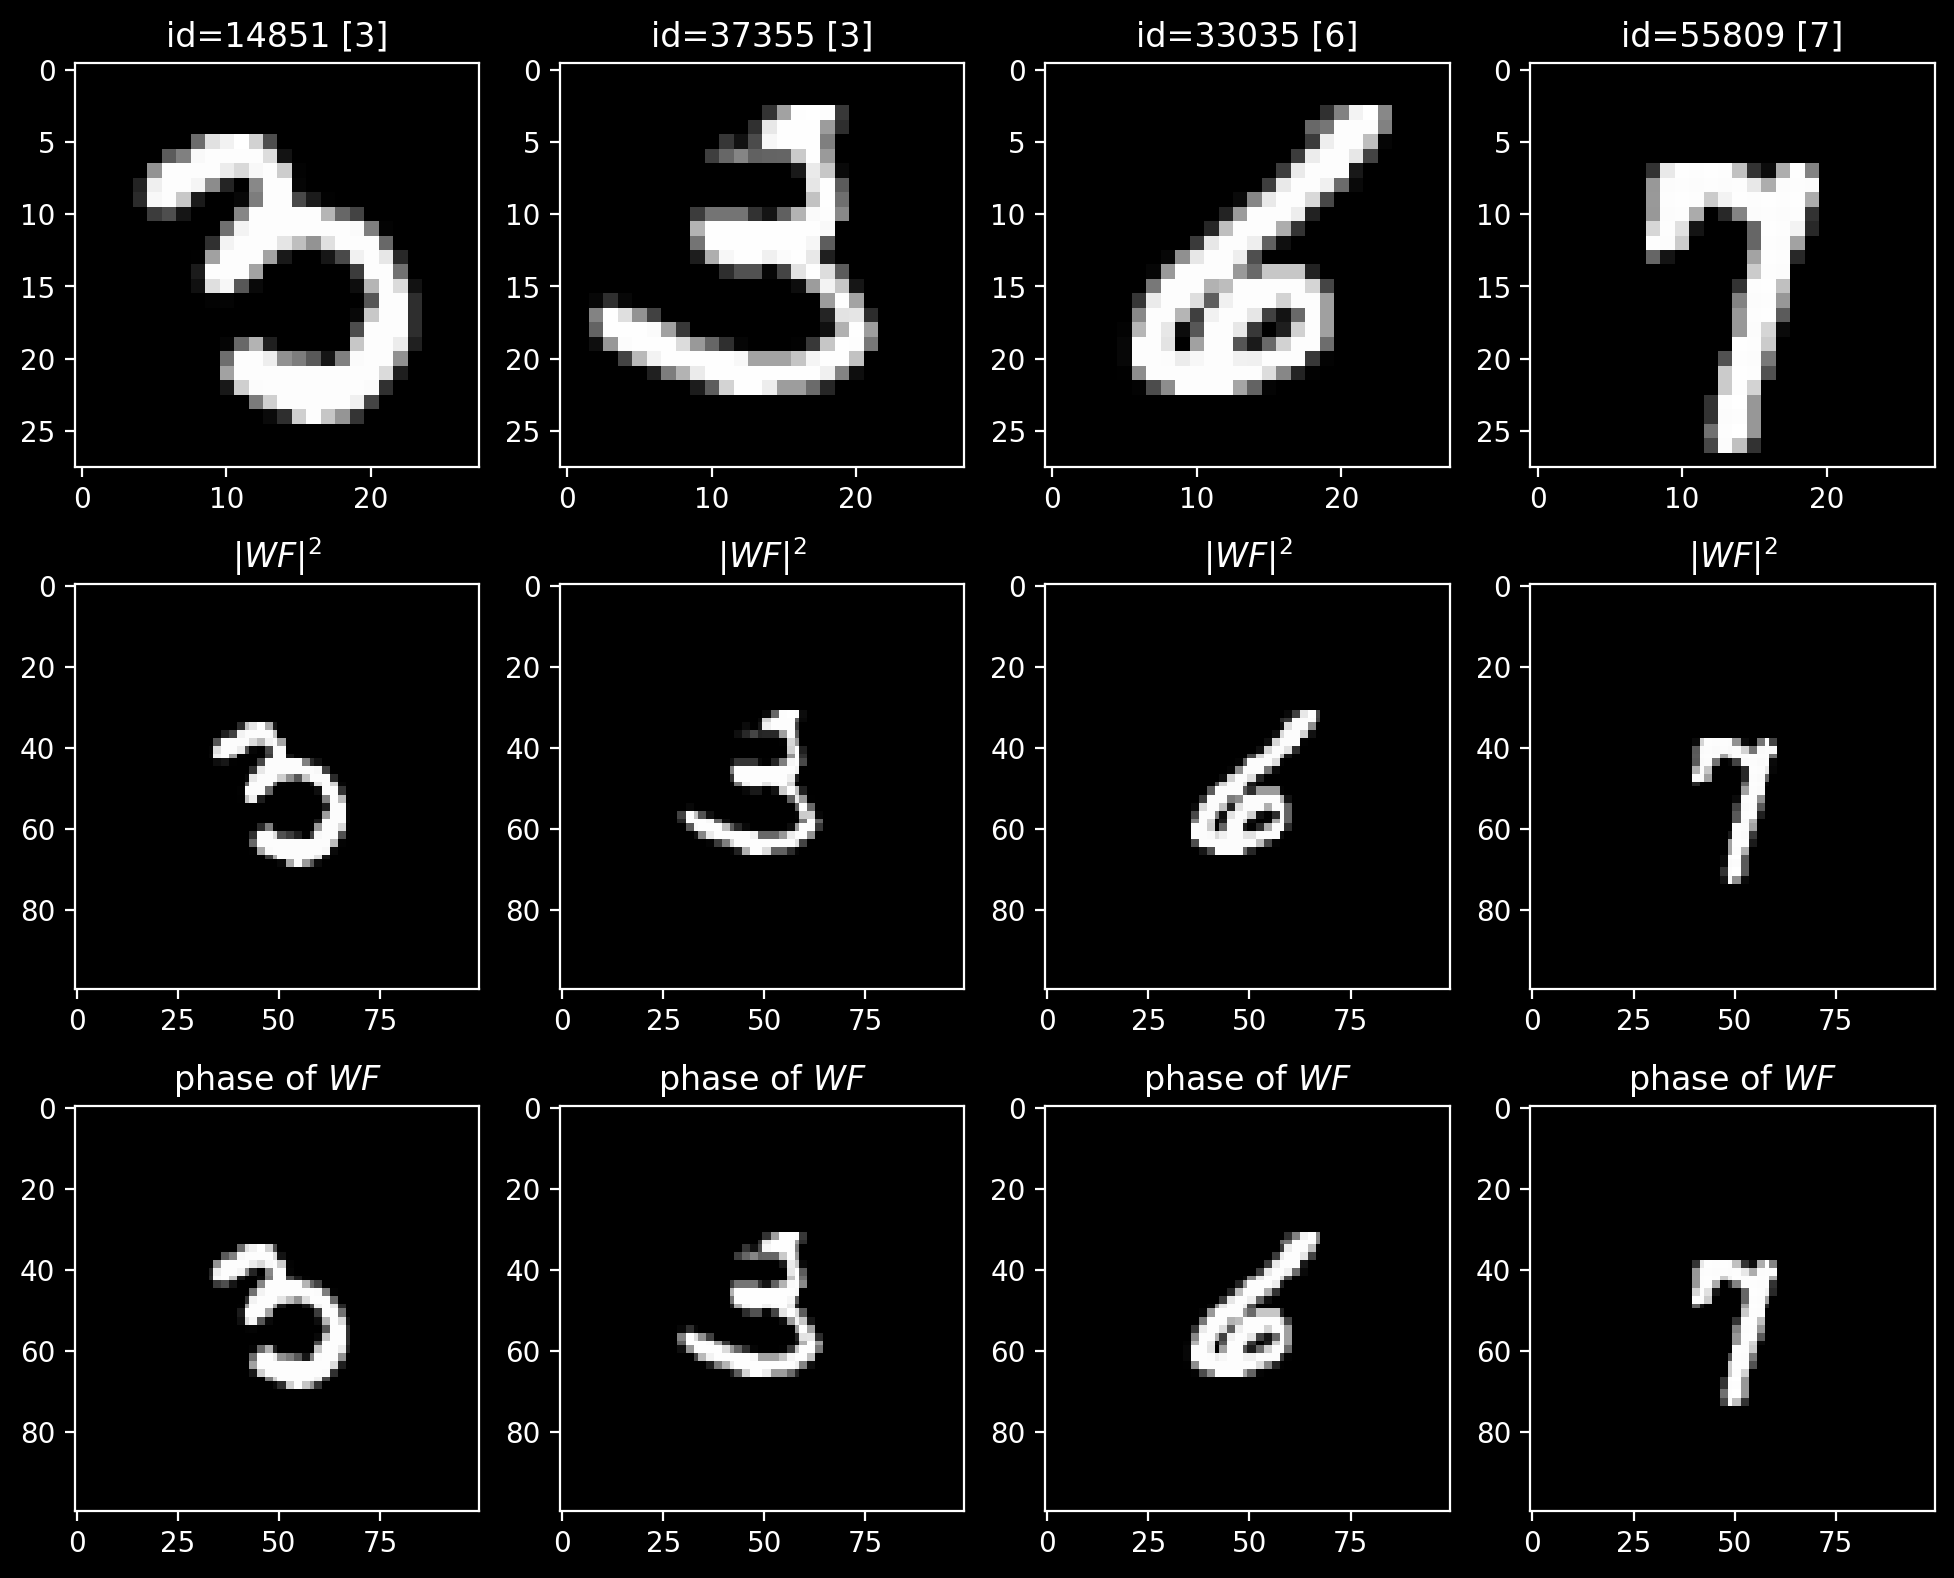

In [28]:
# plot several images
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf02_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(wavefront.intensity[0], cmap='gray')
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(wavefront.phase[0], cmap='gray')

plt.show()